<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Pakistan</h1>

Dataset is downloaded from here: https://www.kaggle.com/datasets/jillanisofttech/pakistan-house-price-dataset

In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load pakistan home prices into a dataframe</h2>

In [77]:
df1 = pd.read_csv("pakistan_house_prices.csv")
df1.head()

C:\Users\waqas\AppData\Local\Temp\ipykernel_15996\2334963485.py:1: DtypeWarning: Columns (0,1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("pakistan_house_prices.csv")


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,G-10,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,E-11,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,G-15,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Bani Gala,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,DHA Defence,2 BHK,NaN,1200,2.0,1.0,51.00


In [78]:
df1.shape

(168446, 9)

In [79]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [80]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area', nan], dtype=object)

In [81]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

**Drop features that are not required to build our model**

In [82]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(168446, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [83]:
df2.isnull().sum()

location           0
size          155142
total_sqft    155126
bath          155199
price         155126
dtype: int64

In [84]:
df2.shape

(168446, 5)

In [85]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [86]:
df3.shape

(13247, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [87]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\waqas\AppData\Local\Temp\ipykernel_15996\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [88]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [89]:
2+3

5

In [90]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,E-11,4 BHK,2100 - 2850,4.0,186.000,4
122,Askari 13,4 BHK,3067 - 8156,4.0,477.000,4
137,Askari 13,2 BHK,1042 - 1105,2.0,54.005,2
165,Scheme 33,2 BHK,1145 - 1340,2.0,43.490,2
188,Malir,2 BHK,1015 - 1540,2.0,56.800,2
410,DHA Defence,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Clifton,2 BHK,1195 - 1440,2.0,63.770,2
648,Cantt,9 Bedroom,4125Perch,9.0,265.000,9
661,Valencia Housing Society,2 BHK,1120 - 1145,2.0,48.130,2
672,Bahria Town Rawalpindi,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [91]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [92]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,G-10,2 BHK,1056.0,2.0,39.07,2
1,E-11,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [93]:
df4.loc[30]

location        E-11
size           4 BHK
total_sqft    2475.0
bath             4.0
price          186.0
bhk                4
Name: 30, dtype: object

In [94]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [95]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,G-10,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,E-11,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,G-15,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Bani Gala,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,DHA Defence,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [96]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320100e+04
mean     7.920566e+03
std      1.067231e+05
min      2.678298e+02
25%      4.267782e+03
50%      5.438066e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [97]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [98]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
DHA Defence               1387
Bahria Town Rawalpindi     648
Gulshan-e-Iqbal Town       430
Gulistan-e-Jauhar          425
Bahria Town                344
                          ... 
C-18                         1
Dhoke Munshi Khan            1
Wazir Town                   1
Islamabad Farm Houses        1
Orchard Scheme               1
Name: count, Length: 969, dtype: int64

In [99]:
location_stats.values.sum()

13201

In [100]:
len(location_stats[location_stats>10])

196

In [101]:
len(location_stats)

969

In [102]:
len(location_stats[location_stats<=10])

773

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [103]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Sea View Apartments      10
Ghaziabad                10
9th Avenue               10
Bahria Nasheman          10
Manawan                  10
                         ..
C-18                      1
Dhoke Munshi Khan         1
Wazir Town                1
Islamabad Farm Houses     1
Orchard Scheme            1
Name: count, Length: 773, dtype: int64

In [104]:
len(df5.location.unique())

969

In [105]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

197

In [106]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,G-10,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,E-11,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,G-15,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Bani Gala,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,DHA Defence,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Ghauri Town,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Korang Town,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,E-11,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,DHA Defence,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,F-11,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [107]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,F-11,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,E-11,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,other,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Chungi Amar Sadhu,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,Askari,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [108]:
df5.shape

(13201, 7)

In [109]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12457, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [110]:
df6.price_per_sqft.describe()

count     12457.000000
mean       6308.427888
std        4167.968413
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [111]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10862, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

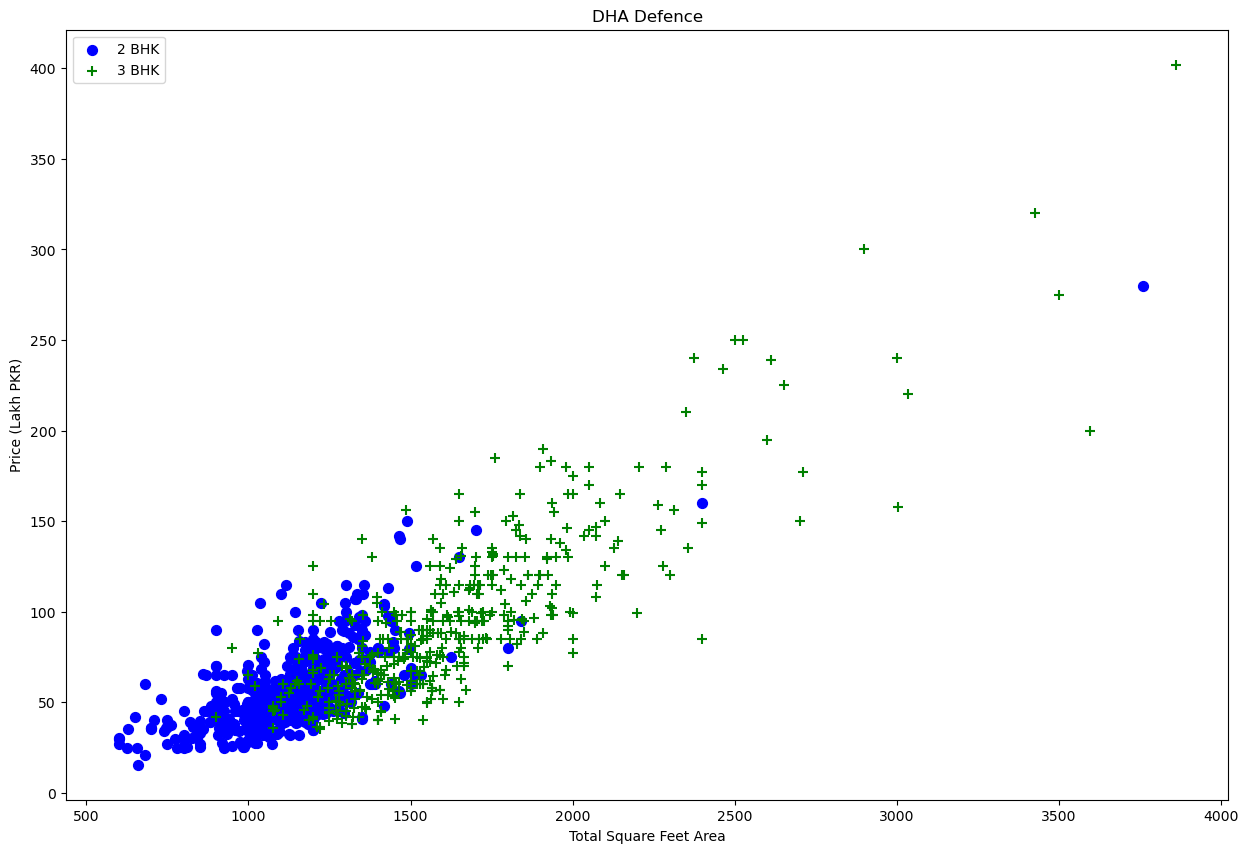

In [112]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh PKR)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"DHA Defence")

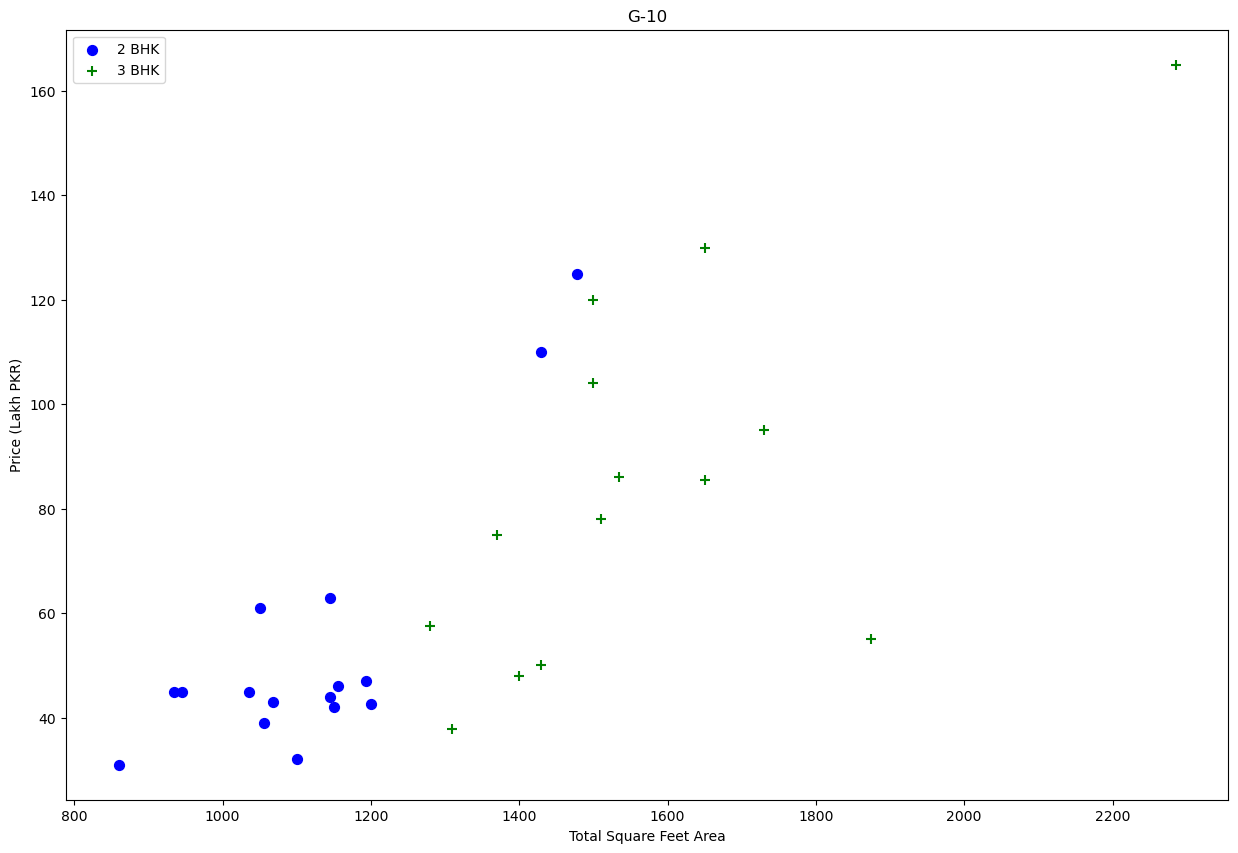

In [113]:
plot_scatter_chart(df7,"G-10")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [114]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7069, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

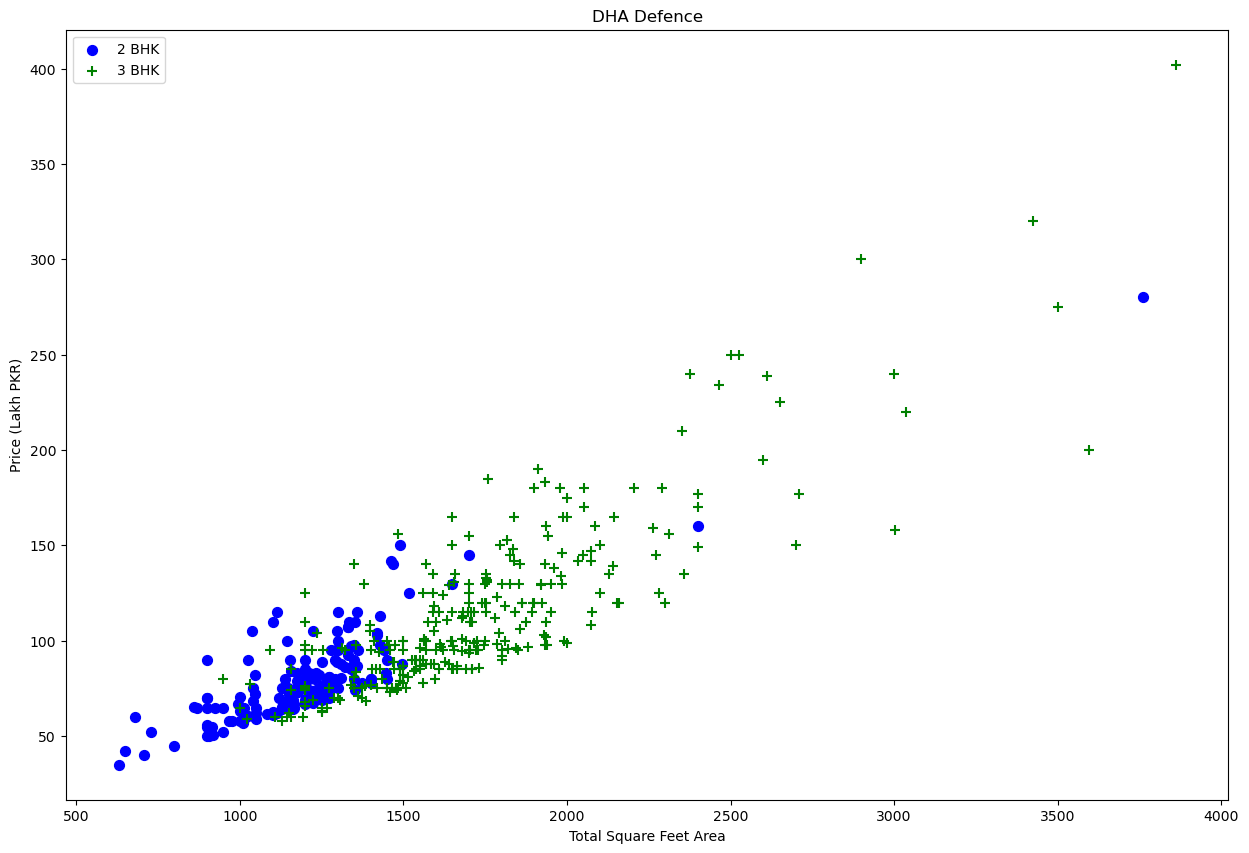

In [115]:
plot_scatter_chart(df8,"DHA Defence")

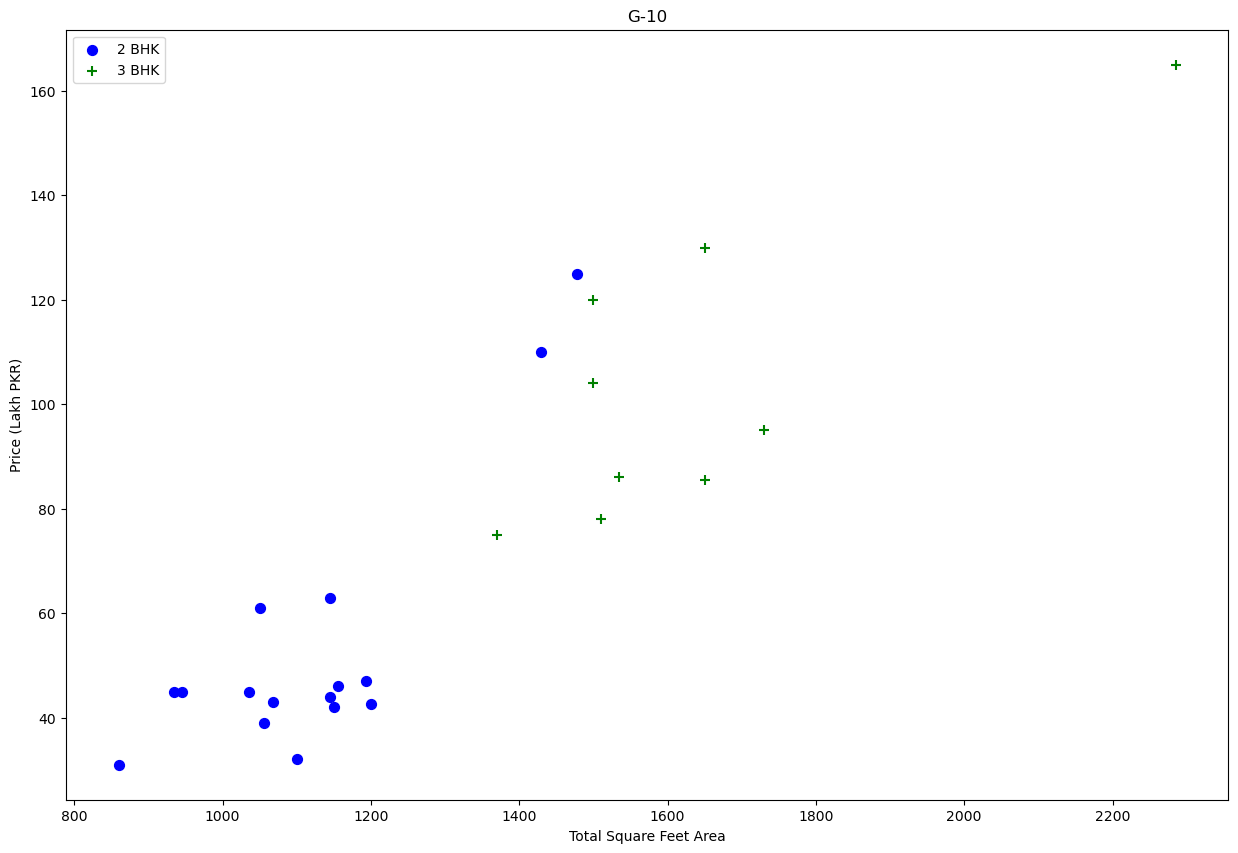

In [116]:
plot_scatter_chart(df8,"G-10")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

Text(0, 0.5, 'Count')

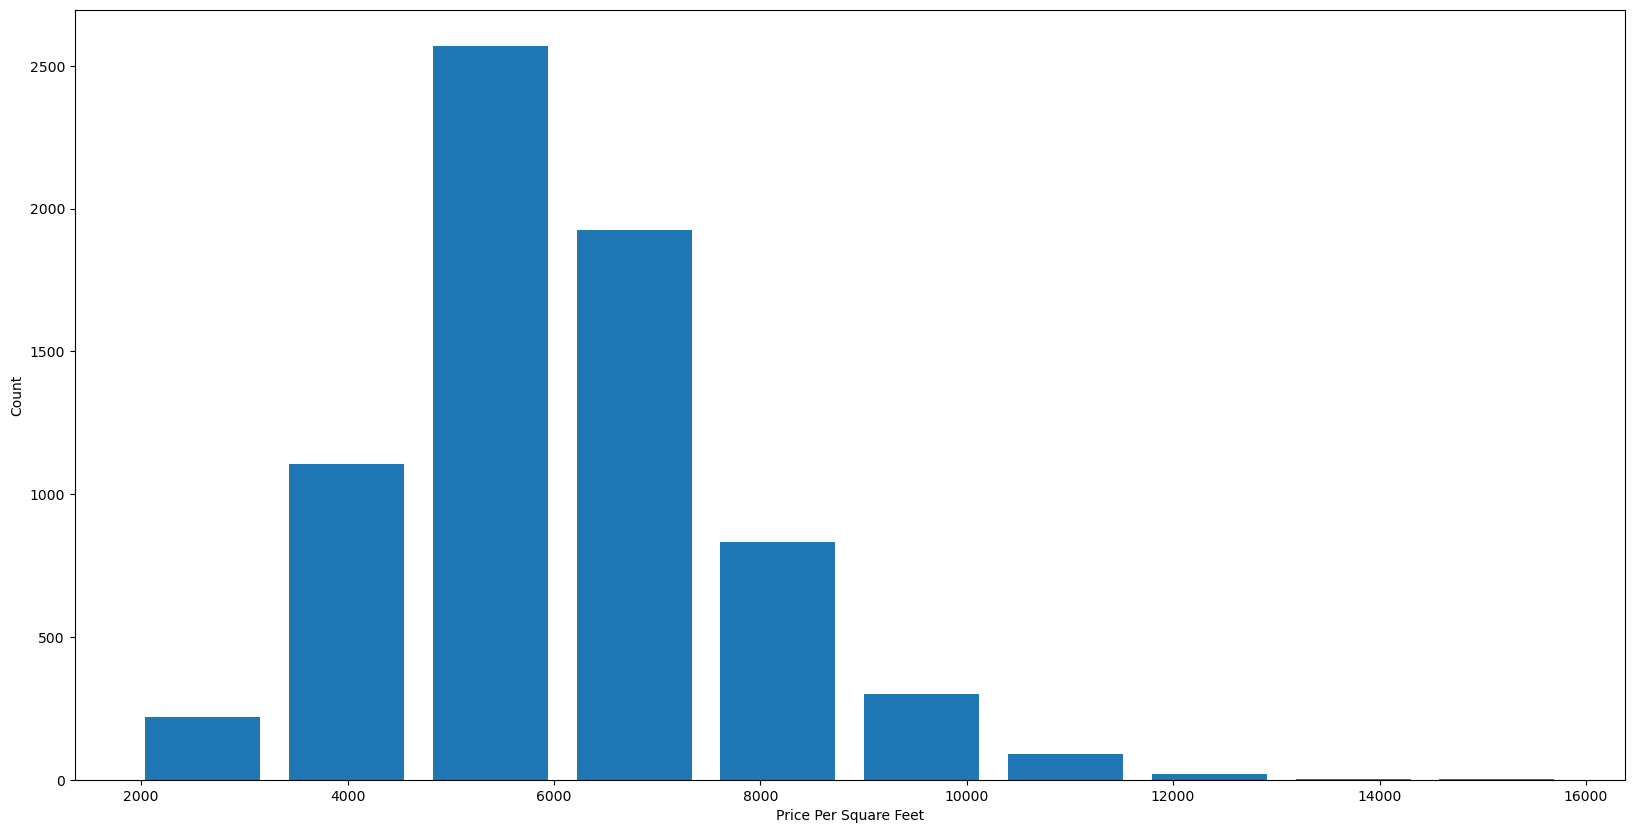

In [117]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [118]:
df8.bath.unique()

array([ 2.,  3.,  4.,  1.,  5.,  8.,  6., 12.,  7.,  9., 13., 16.])

Text(0, 0.5, 'Count')

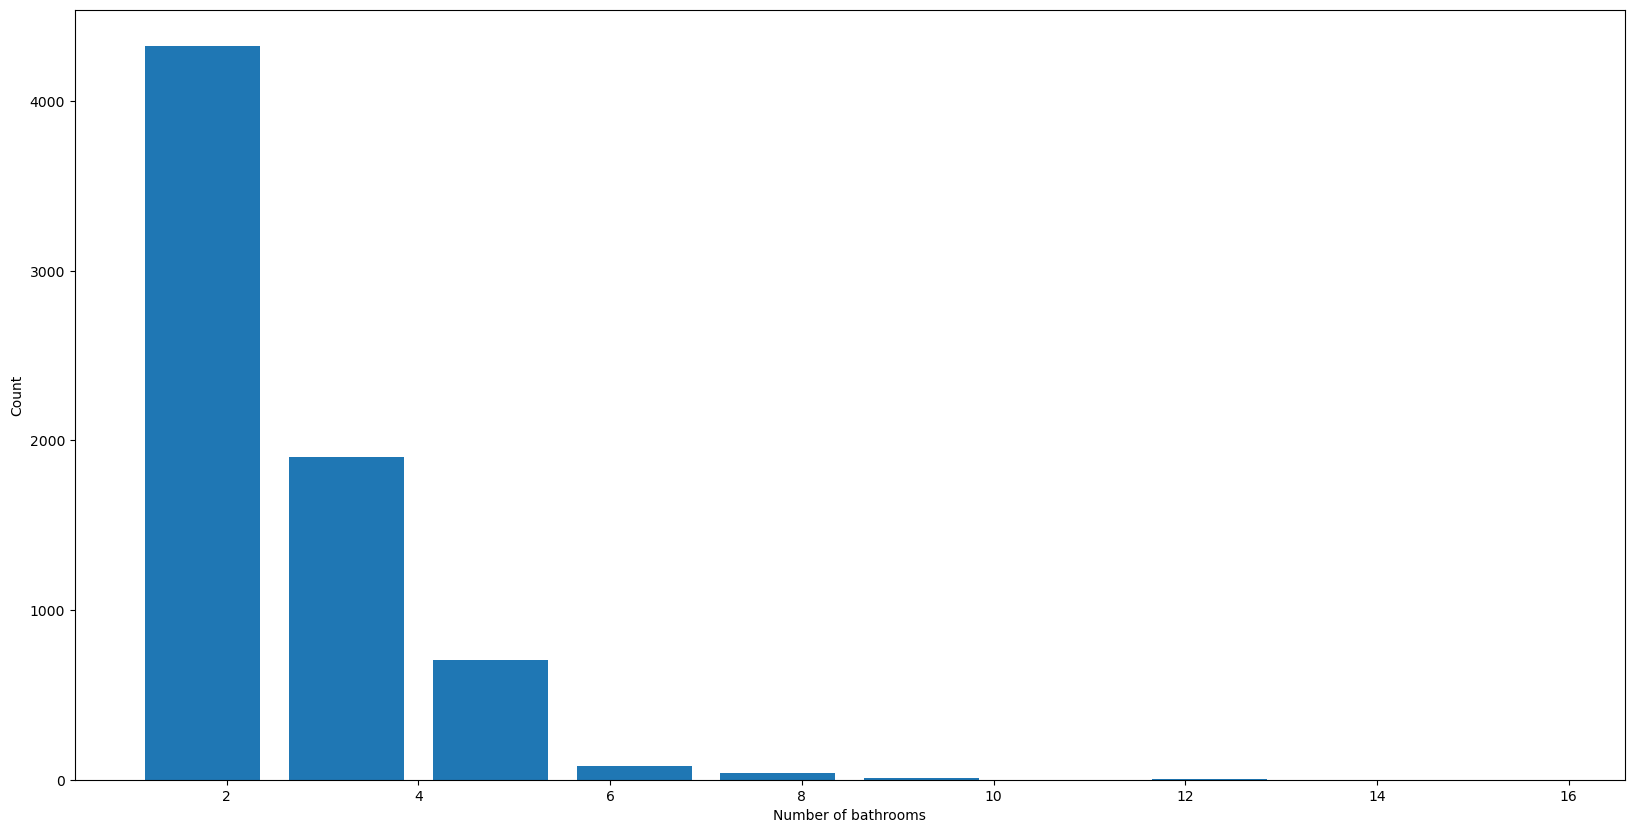

In [119]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [120]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
356,Askari,10 BHK,12000.0,12.0,525.0,10,4375.000000
1483,Bahria Town Rawalpindi,13 BHK,5425.0,13.0,275.0,13,5069.124424
4778,G-11,10 BHK,4000.0,12.0,160.0,10,4000.000000
4936,G-15,16 BHK,10000.0,16.0,550.0,16,5500.000000


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [121]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
545,B-17,3 BHK,1806.0,6.0,116.0,3,6423.034330
3255,DHA Defence,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
5580,Gulistan-e-Jauhar,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [122]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(6993, 7)

In [123]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,7th Avenue,2 BHK,1089.0,2.0,43.55,2,3999.081726
1,7th Avenue,3 BHK,1700.0,3.0,95.00,3,5588.235294


In [124]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,7th Avenue,1089.0,2.0,43.55,2
1,7th Avenue,1700.0,3.0,95.00,3
2,7th Avenue,1500.0,2.0,88.00,2


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [125]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,7th Avenue,Aashiana Road,Abul Hassan Isphani Road,Adiala Road,Afshan Colony,Airport,Airport Housing Society,Al Rehman Garden,Alfalah Town,Ali Pur,...,Thokar Niaz Baig,Township,University Road,Valencia Housing Society,Walton Road,Wapda Town,Wassanpura,Westridge,Zamzama,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [126]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,7th Avenue,Aashiana Road,Abul Hassan Isphani Road,Adiala Road,Afshan Colony,...,Tariq Road,Thokar Niaz Baig,Township,University Road,Valencia Housing Society,Walton Road,Wapda Town,Wassanpura,Westridge,Zamzama
0,7th Avenue,1089.0,2.0,43.55,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7th Avenue,1700.0,3.0,95.00,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,7th Avenue,1500.0,2.0,88.00,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,7th Avenue,1020.0,2.0,48.00,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7th Avenue,1007.0,2.0,67.00,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [127]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,7th Avenue,Aashiana Road,Abul Hassan Isphani Road,Adiala Road,Afshan Colony,Airport,...,Tariq Road,Thokar Niaz Baig,Township,University Road,Valencia Housing Society,Walton Road,Wapda Town,Wassanpura,Westridge,Zamzama
0,1089.0,2.0,43.55,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1700.0,3.0,95.00,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style='color:blue'>Build a Model Now...</h2>

In [128]:
df12.shape

(6993, 200)

In [129]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,7th Avenue,Aashiana Road,Abul Hassan Isphani Road,Adiala Road,Afshan Colony,Airport,Airport Housing Society,...,Tariq Road,Thokar Niaz Baig,Township,University Road,Valencia Housing Society,Walton Road,Wapda Town,Wassanpura,Westridge,Zamzama
0,1089.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1700.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1500.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [130]:
X.shape

(6993, 199)

In [131]:
y = df12.price
y.head(3)

0    43.55
1    95.00
2    88.00
Name: price, dtype: float64

In [132]:
len(y)

6993

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [134]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8084274685808824

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [135]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.77667826, 0.80828867, 0.80263425, 0.8117566 , 0.77330778])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [136]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'copy_X': [True, False],
                'positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Assuming you have X and y defined somewhere
# Call the function to find the best model
find_best_model_using_gridsearchcv(X, y)


C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\base.py", line 

,model,best_score,best_params
0,linear_regression,0.794533,"{'copy_X': True, 'fit_intercept': True, 'posit..."
1,lasso,0.791111,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.715823,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [137]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [138]:
predict_price('Bani Gala',1000, 2, 2)

C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


55.552545545794175

In [139]:
predict_price('Korang Town',1000, 3, 3)

C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


44.75194098757295

In [140]:
predict_price('F-7',1000, 2, 2)

C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


45.75925059020437

In [141]:
predict_price('Gulberg',1000, 3, 3)

C:\Users\waqas\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


49.3274558199345

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [142]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [143]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))